Guide RNAs can sometimes lead to off-target effects or exhibit variable efficacy in genome editing, underscoring the necessity for computational quality control to predict and enhance their specificity and performance.
Mixscape classifies targeted cells based on their response to a perturbation into perturbed and not perturbed.
To do so, mixscape analyzes each cell's "perturbation signature" and then categorizes the cell into either a 'perturbed' or 'escaping' subclass.

This vignette reproduces the [mixscape vignette](https://satijalab.org/seurat/articles/mixscape_vignette.html).

In particular, we show how to use mixscape for the analyses of single-cell pooled CRISPR screens by:

1. Calculating the perturbation-specific signature of every cell.
2. Identifying and removing cells that have ‘escaped’ CRISPR perturbation.
3. Visualizing similarities/differences across different perturbations.

## Setup

In [1]:
import muon as mu
import pertpy as pt
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from scipy.sparse import issparse
from sklearn.linear_model import LinearRegression

Unable to contact PyPI to check for the latest pertpy version. Do you have an internet connection?

Global seed set to 0
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/pertpy/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
/home/icb/soroor.hediyeh-zadeh/miniconda3/envs/pertpy/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

## Dataset

We use the Papalexi ECCITE-seq 111 gRNA ECCITE-seq dataset which was generated from stimulated THP-1 cells.

In [2]:
mdata = pt.dt.papalexi_2021()

In [3]:
mdata

MuData object with n_obs × n_vars = 20729 × 18776
  4 modalities
    rna:	20729 x 18649
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    adt:	20729 x 4
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    hto:	20729 x 12
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    gdo:	20729 x 111
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'

## Preprocessing

We preprocess both RNA and proteins according to the standard pipelines.

### RNA

In [4]:
mdata["rna"].obs

,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,nCount_GDO,nCount_ADT,nFeature_ADT,percent.mito,MULTI_ID,HTO_classification,guide_ID,gene_target,NT,perturbation,replicate,S.Score,G2M.Score,Phase
index,,,,,,,,,,,,,,,,,,,
l1_AAACCTGAGCCAGAAC,Lane1,17207,3942,99.0,4,576.0,801.0,4,2.295577,rep1-tx,rep1-tx,STAT2g2,STAT2,STAT2g2,Perturbed,rep1,-0.252716,-0.771309,G1
l1_AAACCTGAGTGGACGT,Lane1,9506,2948,35.0,5,190.0,545.0,4,4.512939,rep1-tx,rep1-tx,CAV1g4,CAV1,CAV1g4,Perturbed,rep1,-0.123802,-0.332603,G1
l1_AAACCTGCATGAGCGA,Lane1,15256,4258,66.0,4,212.0,344.0,4,4.116413,rep1-tx,rep1-tx,STAT1g2,STAT1,STAT1g2,Perturbed,rep1,-0.154633,-0.694418,G1
l1_AAACCTGTCTTGTCAT,Lane1,5135,1780,22.0,3,243.0,539.0,4,5.491723,rep1-tx,rep1-tx,CD86g1,CD86,CD86g1,Perturbed,rep1,-0.061262,-0.037820,G1
l1_AAACGGGAGAACAACT,Lane1,9673,2671,99.0,5,198.0,1053.0,4,3.359868,rep1-tx,rep1-tx,IRF7g2,IRF7,IRF7g2,Perturbed,rep1,-0.132188,-0.353156,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l8_TTTGTCAGTCACTTCC,Lane8,20863,4884,294.0,4,290.0,398.0,4,5.469012,rep3-tx,rep3-tx,CMTM6g1,CMTM6,CMTM6g1,Perturbed,rep3,-0.323562,-0.794679,G1
l8_TTTGTCAGTGACGGTA,Lane8,17553,3787,528.0,3,870.0,3042.0,4,2.159175,rep4-tx,rep2-tx,NTg4,NT,NT,NT,rep2,-0.153514,-0.632655,G1
l8_TTTGTCAGTTCCACAA,Lane8,15106,4185,154.0,6,267.0,212.0,4,2.661194,rep3-tx,rep3-tx,ATF2g1,ATF2,ATF2g1,Perturbed,rep3,-0.191933,-0.574283,G1


In [5]:
sc.pp.normalize_total(mdata["rna"])

In [6]:
sc.pp.log1p(mdata["rna"])

In [7]:
sc.pp.highly_variable_genes(mdata["rna"], subset=True)

## Calculating local perturbation signatures mitigates confounding effects

To regress out the confounding effects, we calculate local perturbation signatures.
For each cell, we identify `n_neighbors` cells from the control pool with the most similar mRNA expression profiles.
The perturbation signature is calculated by subtracting the averaged mRNA expression profile of the control neighbors from the mRNA expression profile of each cell.

In [8]:
ms = pt.tl.Mixscape()
ms.perturbation_signature(mdata["rna"], "perturbation", "NT", "replicate")

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [9]:
adata_pert = mdata["rna"].copy()

In [10]:
adata_pert.X = adata_pert.layers["X_pert"]

In [11]:
sc.pp.pca(adata_pert)

In [12]:
sc.pp.neighbors(adata_pert, metric="cosine")

In [13]:
sc.tl.umap(adata_pert)

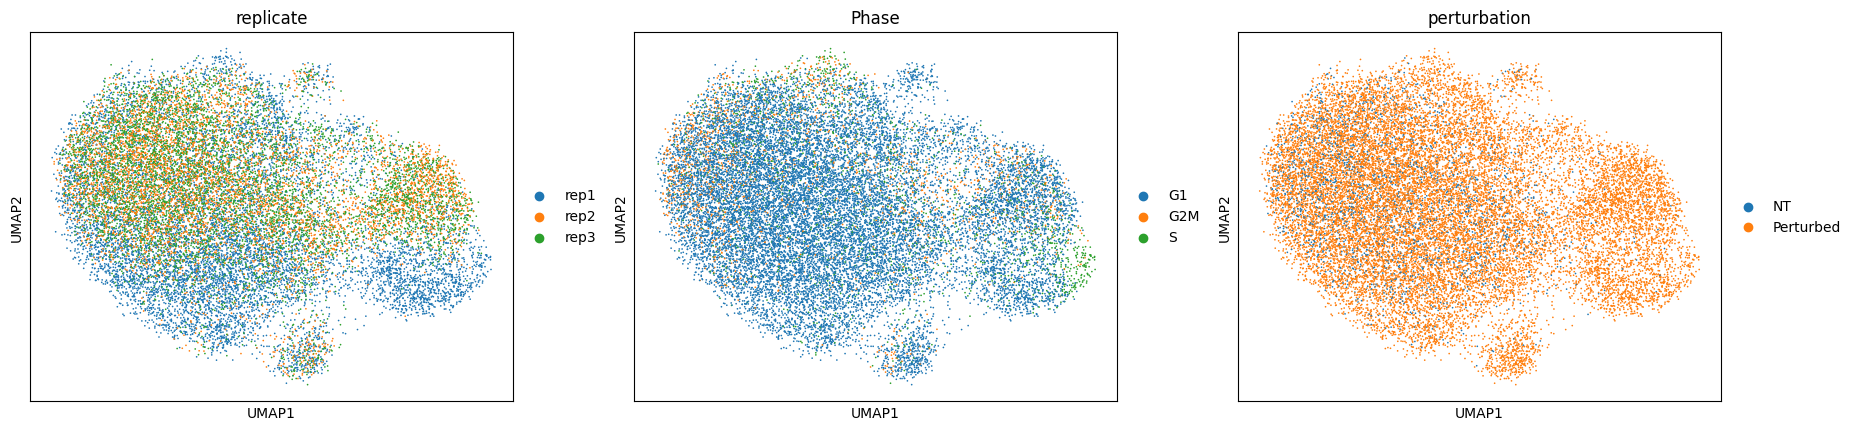

In [14]:
sc.pl.umap(adata_pert, color=["replicate", "Phase", "perturbation"])

## Mixscape identifies cells with no detectable perturbation

mixscape models each target gene class as a combination of two Gaussian distributions: one for knockout (KO) cells and another for non-perturbed (NP) cells.
We assume that NP cells exhibit the same distribution as cells with non-targeting gRNAs (NT).
We estimate the KO cell distribution and then compute the posterior probability of a cell belonging to the KO group.
Cells with a probability above 0.5 are classified as KOs.
This method helped us identify KOs in 11 target gene classes, revealing variations in gRNA targeting efficiency across these classes.

In [15]:
ms.mixscape(adata=mdata["rna"], control="NT", labels="gene_target", layer="X_pert")

In [16]:
mdata["rna"].obs[['guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate']]

,guide_ID,gene_target,NT,perturbation,replicate
index,,,,,
l1_AAACCTGAGCCAGAAC,STAT2g2,STAT2,STAT2g2,Perturbed,rep1
l1_AAACCTGAGTGGACGT,CAV1g4,CAV1,CAV1g4,Perturbed,rep1
l1_AAACCTGCATGAGCGA,STAT1g2,STAT1,STAT1g2,Perturbed,rep1
l1_AAACCTGTCTTGTCAT,CD86g1,CD86,CD86g1,Perturbed,rep1
l1_AAACGGGAGAACAACT,IRF7g2,IRF7,IRF7g2,Perturbed,rep1
...,...,...,...,...,...
l8_TTTGTCAGTCACTTCC,CMTM6g1,CMTM6,CMTM6g1,Perturbed,rep3
l8_TTTGTCAGTGACGGTA,NTg4,NT,NT,NT,rep2
l8_TTTGTCAGTTCCACAA,ATF2g1,ATF2,ATF2g1,Perturbed,rep3


In [17]:
pd.crosstab(mdata["rna"].obs['gene_target'], mdata["rna"].obs['replicate'])

replicate,rep1,rep2,rep3
gene_target,,,
ATF2,481,286,335
BRD4,122,83,136
CAV1,357,239,286
CD86,560,309,328
CMTM6,345,214,258
CUL3,136,69,69
ETV7,367,204,270
IFNGR1,680,331,330
IFNGR2,522,306,385


In [18]:
pd.set_option("display.max_columns", None)

pd.crosstab(mdata["rna"].obs['gene_target'], mdata["rna"].obs['mixscape_class'])

mixscape_class,ATF2 NP,BRD4 KO,BRD4 NP,CAV1 NP,CD86 NP,CMTM6 NP,CUL3 KO,CUL3 NP,ETV7 NP,IFNGR1 KO,IFNGR1 NP,IFNGR2 KO,IFNGR2 NP,IRF1 KO,IRF1 NP,IRF7 NP,JAK2 KO,JAK2 NP,MARCH8 NP,MYC KO,MYC NP,NFKBIA NP,NT,PDCD1LG2 NP,POU2F2 NP,SMAD4 KO,SMAD4 NP,SPI1 KO,SPI1 NP,STAT1 KO,STAT1 NP,STAT2 KO,STAT2 NP,STAT3 NP,STAT5A NP,TNFRSF14 NP,UBE2L6 NP
gene_target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ATF2,1102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BRD4,0,144,197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CAV1,0,0,0,882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CD86,0,0,0,0,1197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CMTM6,0,0,0,0,0,817,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CUL3,0,0,0,0,0,0,142,132,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ETV7,0,0,0,0,0,0,0,0,841,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
IFNGR1,0,0,0,0,0,0,0,0,0,963,378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
IFNGR2,0,0,0,0,0,0,0,0,0,0,0,897,316,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
# Extract control cells
control_cells = mdata["rna"][mdata["rna"].obs['mixscape_class'] == 'NT'].copy()
sc.pp.subsample(control_cells, n_obs = 1000)
control_cells = control_cells.X.todense()

# # Extract NP (Non-Perturbed) cells
# np_cells = mdata["rna"][mdata["rna"].obs['mixscape_class'].str.endswith(' NP')].X.todense()

gene = 'IFNGR2'  # 'IFNGR2', 'CUL3', 'JAK2', 'MYC', 'STAT2', 'IRF1' 

# Extract single KO NP  cells
np_cells = mdata["rna"][(mdata["rna"].obs['gene_target'].isin([gene])) & (mdata["rna"].obs['mixscape_class'].str.endswith(' NP'))].X.todense()


# Extract KO (Knockout) cells
ko_cells = mdata["rna"][mdata["rna"].obs['mixscape_class'].str.endswith(' KO')].X.todense()


# Extract STAT5A KO  cells
singleko_cells = mdata["rna"][(mdata["rna"].obs['gene_target'].isin([gene])) & (mdata["rna"].obs['mixscape_class'].str.endswith(' KO'))].X.todense()

rep1_KO_cells = mdata["rna"][
    (mdata["rna"].obs['mixscape_class'].str.endswith(' KO')) & 
    (mdata["rna"].obs['replicate'] == "rep1")
].X.todense()

# Print shapes to verify the results
print(f"Control cells shape: {control_cells.shape}")
print(f"NP cells shape: {np_cells.shape}")
print(f"KO cells shape: {ko_cells.shape}")
print(f"rep1_KO cells shape: {rep1_KO_cells.shape}")
print(f"single_KO cells shape: {singleko_cells.shape}")




Control cells shape: (1000, 1917)
NP cells shape: (316, 1917)
KO cells shape: (5187, 1917)
rep1_KO cells shape: (2466, 1917)
single_KO cells shape: (897, 1917)


In [76]:
mdata["rna"].obs['mixscape_class']

index
l1_AAACCTGAGCCAGAAC    STAT2 KO
l1_AAACCTGAGTGGACGT     CAV1 NP
l1_AAACCTGCATGAGCGA    STAT1 KO
l1_AAACCTGTCTTGTCAT     CD86 NP
l1_AAACGGGAGAACAACT     IRF7 NP
                         ...   
l8_TTTGTCAGTCACTTCC    CMTM6 NP
l8_TTTGTCAGTGACGGTA          NT
l8_TTTGTCAGTTCCACAA     ATF2 NP
l8_TTTGTCATCACGCATA     CAV1 NP
l8_TTTGTCATCTGTACGA    STAT3 NP
Name: mixscape_class, Length: 20729, dtype: object

In [77]:
# transforming edgeR source code for mean-var plot to python code


# Define the functions
def bin_mean_var(x, group, nbins=100, common_dispersion=False, object=None):
    x = np.asarray(x)
    group = pd.Categorical(group)
    ntags, nlibs = x.shape
    means = np.mean(x, axis=1)

    if len(np.unique(group)) > 1:
        design = pd.get_dummies(group)
        model = OLS(x.T, add_constant(design)).fit()
        vars_ = model.mse_resid
    else:
        vars_ = np.sum((x - means[:, None]) ** 2, axis=1) / (nlibs - 1)

    bins = []
    var_bins = []
    means_bins = []
    o = np.argsort(means)
    ntags_in_bin = ntags // nbins

    if common_dispersion:
        comdisp_bin = np.full(nbins, np.nan)
        dispersions = np.full(ntags, np.nan)
    else:
        dispersions = None

    for i in range(nbins):
        if i == nbins - 1:
            bin_indices = o[(i * ntags_in_bin):]
        else:
            bin_indices = o[(i * ntags_in_bin):((i + 1) * ntags_in_bin)]
        bins.append(bin_indices)
        means_bins.append(means[bin_indices])
        var_bins.append(vars_[bin_indices])

        if common_dispersion and object is not None:
            comdisp_bin[i] = estimate_common_disp(object[bin_indices, :])
            dispersions[bin_indices] = comdisp_bin[i]

    sqrt_means = [np.sqrt(mb) for mb in means_bins]
    sqrt_vars = [np.sqrt(vb) for vb in var_bins]
    ave_means = np.array([np.mean(sm) ** 2 for sm in sqrt_means])
    ave_vars = np.array([np.mean(sv) ** 2 for sv in sqrt_vars])

    if common_dispersion:
        comdisp_vars = ave_means + comdisp_bin * ave_means ** 2
    else:
        comdisp_vars = None
        comdisp_bin = None

    return {
        'avemeans': ave_means,
        'avevars': ave_vars,
        'bin_means': means_bins,
        'bin_vars': var_bins,
        'means': means,
        'vars': vars_,
        'common_dispersion_vars': comdisp_vars,
        'binned_common_dispersion': comdisp_bin,
        'dispersions': dispersions,
        'bins': bins
    }

def plot_mean_var(meanvar, title, log_axes='xy', xlab=None, ylab=None, show_raw=True, **kwargs):
    avemeans = meanvar['avemeans']
    avevars = meanvar['avevars']
    common_dispersion_vars = meanvar['common_dispersion_vars']

    if xlab is None:
        xlab = "Mean gene expression level (log10 scale)"
    if ylab is None:
        ylab = "Pooled gene-level variance (log10 scale)"

    plt.figure()
    if show_raw:
        plt.scatter(meanvar['means'], meanvar['vars'], color='gray', s=10, label='Raw Vars', **kwargs)
    plt.scatter(avemeans, avevars, color='darkred', s=50, marker='x', label='Ave Raw Vars')
    if common_dispersion_vars is not None:
        plt.scatter(avemeans, common_dispersion_vars, color='firebrick', s=50, marker='x', label='Binned Common Disp Vars')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()


# Compute mean-variance data
control_meanvar = bin_mean_var(control_cells, np.zeros(control_cells.shape[1]))
np_meanvar = bin_mean_var(np_cells, np.zeros(np_cells.shape[1]))
ko_meanvar = bin_mean_var(ko_cells, np.zeros(ko_cells.shape[1]))
ko_rep1_meanvar = bin_mean_var(rep1_KO_cells, np.zeros(rep1_KO_cells.shape[1]))
singleko_cells_meanvar = bin_mean_var(singleko_cells, np.zeros(singleko_cells.shape[1]))

# Plot mean-variance data
# plot_mean_var(control_meanvar, title='Control Cells')
# plot_mean_var(np_meanvar, title='NP Cells')
# plot_mean_var(ko_meanvar, title='KO Cells')
# plot_mean_var(ko_rep1_meanvar, title='KO_rep1 Cells')



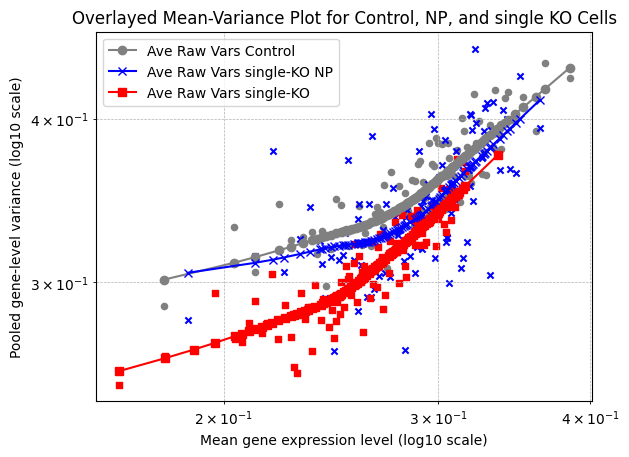

In [78]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def smoothing(x, y):
    lowess_frac = 0.8  # size of data (%) for estimation =~ smoothing window
    lowess_it = 0
    x_smooth = x
    y_smooth = lowess(y, x, is_sorted=False, frac=lowess_frac, it=lowess_it, return_sorted=False)
    return x_smooth, y_smooth


def plot_mean_var_overlay(meanvar_list, labels, title, log_axes='xy', xlab=None, ylab=None, show_raw=False, **kwargs):
    if xlab is None:
        xlab = "Mean gene expression level (log10 scale)"
    if ylab is None:
        ylab = "Pooled gene-level variance (log10 scale)"

    colors = ['gray', 'blue', 'red']
    markers = ['o', 'x', 's']

    plt.figure()
    for i, meanvar in enumerate(meanvar_list):
        avemeans = meanvar['avemeans']
        avevars = meanvar['avevars']
        common_dispersion_vars = meanvar['common_dispersion_vars']
        xloess, yloess = smoothing(meanvar['avemeans'], meanvar['avevars'])

        if show_raw:
            plt.scatter(meanvar['means'], meanvar['vars'], color=colors[i], s=10, alpha=0.5, label=f'Raw Vars {labels[i]}', **kwargs)
        plt.scatter(avemeans, avevars, color=colors[i], s=20, marker=markers[i]) # , label=f'Ave Raw Vars {labels[i]}'
        plt.plot(xloess, yloess, color=colors[i], marker=markers[i], label=f'Ave Raw Vars {labels[i]}')
        if common_dispersion_vars is not None:
            plt.scatter(avemeans, common_dispersion_vars, color=colors[i], s=20, marker=markers[i], edgecolor='black', label=f'Binned Common Disp Vars {labels[i]}')
           
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()

# Plot mean-variance data overlay
plot_mean_var_overlay(
    [control_meanvar, np_meanvar, singleko_cells_meanvar],
    ['Control', 'single-KO NP', 'single-KO'],
    title='Overlayed Mean-Variance Plot for Control, NP, and single KO Cells'
)

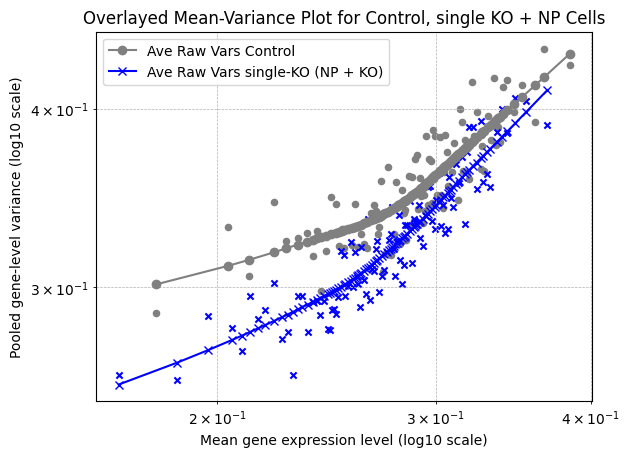

In [79]:
# control vs single KO (ignoring scaping)


all_singleKO = np.concatenate((singleko_cells,np_cells))
singleko_cells_meanvar = bin_mean_var(all_singleKO, np.zeros(all_singleKO.shape[1]))




plot_mean_var_overlay(
    [control_meanvar, singleko_cells_meanvar],
    ['Control', 'single-KO (NP + KO)'],
    title='Overlayed Mean-Variance Plot for Control, single KO + NP Cells'
)